In [ ]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 3.0 MB/s eta 0:00:00
  Atte

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, PReLU, BatchNormalization
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2
import os

In [ ]:
## 데이터 로드 ##
data = np.load('/content/drive/MyDrive/velocity_data_1000_128_1_128.npy')

y_fixed = 0  # 슬라이스 고정
processed_data = data[:, :, y_fixed, :, :]  # (1000, 128, 128, 3)

train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=17)

print("최종 데이터 크기:", processed_data.shape)
print("학습 데이터 크기:", train_data.shape)
print("테스트 데이터 크기:", test_data.shape)

최종 데이터 크기: (1000, 128, 128, 3)
학습 데이터 크기: (800, 128, 128, 3)
테스트 데이터 크기: (200, 128, 128, 3)


In [ ]:
## 데이터 로드 ##
data = np.load('/content/drive/MyDrive/velocity_data_1000_256_1_256.npy')

y_fixed = 0  # 슬라이스 고정
processed_data = data[:, :, y_fixed, :, :]  # (1000, 256, 256, 3)

train_data, test_data = train_test_split(processed_data, test_size=0.2, random_state=17)

print("최종 데이터 크기:", processed_data.shape)
print("학습 데이터 크기:", train_data.shape)
print("테스트 데이터 크기:", test_data.shape)

최종 데이터 크기: (1000, 256, 256, 3)
학습 데이터 크기: (800, 256, 256, 3)
테스트 데이터 크기: (200, 256, 256, 3)


In [ ]:
hr_train = train_data.astype('float32')
hr_test = test_data.astype('float32')

In [ ]:
# X
from tensorflow.keras.layers import AveragePooling2D
from scipy.ndimage import zoom

def generator_pooling(velocity_data, pool_size=(8, 8), upscale_factor=8, method='bicubic'):
    """
    속도장 데이터를 풀링하여 저해상도로 변환하고 보간법으로 원본 크기로 복원하는 함수
    Args:
        velocity_data (numpy array): 고해상도 속도장 데이터 배열
        pool_size (tuple): 풀링 크기 (height, width)
        upscale_factor (int): 크기를 복원할 배율
        method (str): 보간법 ('bicubic', 'bilinear' 등)
    Returns:
        numpy array: 크기 복원된 저해상도 속도장 데이터 배열
    """
    lr_data = []
    lr_pooled_data = []

    for field in velocity_data:
        # Average Pooling 적용
        pool_layer = AveragePooling2D(pool_size=pool_size)
        field_lr = pool_layer(field[np.newaxis, ...])
        field_lr = field_lr.numpy()[0, ...]

        lr_pooled_data.append(field_lr)

        # 보간법 적용
        if method == 'bicubic':
            field_hr = cv2.resize(field_lr, (field_lr.shape[1] * upscale_factor,
                                             field_lr.shape[0] * upscale_factor),
                                  interpolation=cv2.INTER_CUBIC)
        else:
            field_hr = zoom(field_lr, zoom=(upscale_factor, upscale_factor), order=3)

        lr_data.append(field_hr)

    return np.array(lr_data), np.array(lr_pooled_data)

# 저해상도 데이터 생성
lr_train, lr_train_pooled = generator_pooling(hr_train, method='bicubic')
lr_test, lr_test_pooled = generator_pooling(hr_test, method='bicubic')

print("저해상도 학습 데이터 크기:", lr_train.shape)
print("저해상도 테스트 데이터 크기:", lr_test.shape)
print("풀링만 적용한 학습 데이터 크기:", lr_train_pooled.shape)
print("풀링만 적용한 테스트 데이터 크기:", lr_test_pooled.shape)

저해상도 학습 데이터 크기: (800, 256, 256, 3)
저해상도 테스트 데이터 크기: (200, 256, 256, 3)
풀링만 적용한 학습 데이터 크기: (800, 32, 32, 3)
풀링만 적용한 테스트 데이터 크기: (200, 32, 32, 3)


In [ ]:
## 원본 데이터를 average pooling하여 저해상화 (4, 4) 또는 (8, 8) pooling ##
from tensorflow.keras.layers import AveragePooling2D
from scipy.ndimage import zoom

def generator_pooling(velocity_data, pool_size=(4, 4)):
    """
    속도장 데이터를 풀링하여 저해상도로 변환
    Args:
        velocity_data (numpy array): 고해상도 속도장 데이터 배열
        pool_size (tuple): 풀링 크기 (height, width)
    Returns:
        numpy array: 저해상도 속도장 데이터 배열 (32, 32, 3)
    """
    lr_data = []
    lr_pooled_data = []

    for field in velocity_data:
        # Average Pooling 적용
        pool_layer = AveragePooling2D(pool_size=pool_size)
        field_lr = pool_layer(field[np.newaxis, ...])
        field_lr = field_lr.numpy()[0, ...]

        lr_pooled_data.append(field_lr)

    return np.array(lr_pooled_data)

# 저해상도 데이터 생성
lr_train = generator_pooling(hr_train)
lr_test= generator_pooling(hr_test)

print("저해상도 학습 데이터 크기:", lr_train.shape)
print("저해상도 테스트 데이터 크기:", lr_test.shape)

저해상도 학습 데이터 크기: (800, 32, 32, 3)
저해상도 테스트 데이터 크기: (200, 32, 32, 3)


In [ ]:
## 데이터 전처리 ##
# 평균과 표준편차를 이용한 정규화
mean_val = np.mean(lr_train)
std_val = np.std(lr_train)

lr_train = (lr_train - mean_val) / std_val
lr_test = (lr_test - mean_val) / std_val

In [ ]:
# Sequential API로 구현한 모델
import tensorflow.keras.backend as K

## SRCNN 모델 구성 ##
initializer = initializers.HeNormal(seed=33)  # He 초기화

def build_srcnn():
    model = Sequential()
    model.add(Conv2D(filters=128, kernel_size=5, strides=1, padding='same', input_shape=(64, 64, 3)))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same'))
    model.add(PReLU())
    model.add(BatchNormalization())
    model.add(Conv2D(filters=3, kernel_size=3, strides=1, padding='same'))
    return model

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = K.mean(K.square(y_true - y_pred), axis=(1, 2, 3))  # (H, W, C) 차원에 대해 평균 계산
    psnr = 20 * K.log(1.0 / K.sqrt(mse)) / K.log(10.0)  # PSNR 계산 공식
    return psnr

# 모델 생성 및 컴파일
SRCNN = build_srcnn()
SRCNN.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics = [PSNR])

# 모델 구조 출력 (입력 샘플을 주어야 summary 가능)
SRCNN.build(input_shape=(None, 32, 32, 3))
SRCNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 64, 64, 128)       9728      
                                                                 
 p_re_lu_11 (PReLU)          (None, 64, 64, 128)       524288    
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 p_re_lu_12 (PReLU)          (None, 64, 64, 64)        262144    
                                                                 
 batch_normalization_12 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                     

In [ ]:
# subclassing으로 구현한 모델
# srcnn

import tensorflow.keras.backend as K
from tensorflow.keras import Model, layers, initializers

# **SRCNN 모델 구성(subclassing)**
class SRCNN(Model):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)  # He 초기화

        self.conv1 = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', kernel_initializer=self.initializer)  # 입출력 크기를 동일하게 same padding (기본값으로 zero padding)
        self.prelu1 = layers.PReLU()
        self.batchnorm1 = layers.BatchNormalization()

        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()
        self.batchnorm2 = layers.BatchNormalization()

        self.conv3 = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu3 = layers.PReLU()
        self.batchnorm3 = layers.BatchNormalization()

        self.deconv = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)  # 업샘플링 Conv2DTranspose
        self.prelu4 = layers.PReLU()
        self.batchnorm4 = layers.BatchNormalization()

        self.conv4 = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.prelu1(x)
        x = self.batchnorm1(x, training=training)

        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.batchnorm2(x, training=training)

        x = self.conv3(x)
        x = self.prelu3(x)
        x = self.batchnorm3(x, training=training)

        x = self.deconv(x)
        x = self.prelu4(x)
        x = self.batchnorm4(x, training=training)

        x = self.conv4(x)
        return x

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))  # (H, W, C) 차원에 대해 평균 계산
    psnr = 20 * K.log(1.0 / K.sqrt(mse)) / K.log(10.0)  # PSNR 계산 공식
    return psnr

# 모델 생성 및 컴파일
srcnn_model = SRCNN()
srcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[PSNR])

# 모델 구조 출력 (입력 샘플을 주어야 summary 가능)
srcnn_model.build(input_shape=(None, 32, 32, 3))
srcnn_model.summary()

Model: "srcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  2432      
                                                                 
 p_re_lu (PReLU)             multiple                  32768     
                                                                 
 batch_normalization (BatchN  multiple                 128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           multiple                  18496     
                                                                 
 p_re_lu_1 (PReLU)           multiple                  65536     
                                                                 
 batch_normalization_1 (Batc  multiple                 256       
 hNormalization)                                             

In [ ]:
# srcnn + skip connection
# (32, 32, 3) => (128, 128, 3)

import tensorflow as tf
from tensorflow.keras import Model, layers, initializers
from tensorflow.keras.layers import Add, UpSampling2D

class ImprovedSRCNN(Model):
    def __init__(self):
        super(ImprovedSRCNN, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)  # He 초기화

        # 첫 번째 Conv2D Layer
        self.conv1 = layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu1 = layers.PReLU()
        self.batchnorm1 = layers.BatchNormalization()

        # 두 번째 Conv2D Layer
        self.conv2 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()
        self.batchnorm2 = layers.BatchNormalization()

        # 세 번째 Conv2D Layer
        self.conv3 = layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu3 = layers.PReLU()
        self.batchnorm3 = layers.BatchNormalization()

        # Deconvolution Layer (업샘플링)
        self.deconv = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu4 = layers.PReLU()
        self.batchnorm4 = layers.BatchNormalization()

        # 최종 Conv2D Layer
        self.conv4 = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

        # Skip Connection (입력과 출력 합성)
        self.skip_connection_conv = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same', kernel_initializer=self.initializer)

    def call(self, inputs, training=False):
        # 첫 번째 Conv2D
        x1 = self.conv1(inputs)
        x1 = self.prelu1(x1)
        x1 = self.batchnorm1(x1, training=training)

        # 두 번째 Conv2D
        x2 = self.conv2(x1)
        x2 = self.prelu2(x2)
        x2 = self.batchnorm2(x2, training=training)

        # 세 번째 Conv2D
        x3 = self.conv3(x2)
        x3 = self.prelu3(x3)
        x3 = self.batchnorm3(x3, training=training)

        # Deconvolution (업샘플링)
        x4 = self.deconv(x3)
        x4 = self.prelu4(x4)
        x4 = self.batchnorm4(x4, training=training)

        # Skip connection (입력과 출력 합성)
        skip_connection = self.skip_connection_conv(inputs)

        # Skip Connection을 더하여 최종 출력
        output = Add()([x4, skip_connection])

        # 최종 Conv2D (컬러 이미지 출력)
        output = self.conv4(output)
        return output

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))  # (H, W, C) 차원에 대해 평균 계산
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)  # PSNR 계산 공식
    return psnr

# 모델 생성 및 컴파일
isrcnn_model = ImprovedSRCNN()
isrcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[PSNR])

# 모델 구조 출력 (입력 샘플을 주어야 summary 가능)
isrcnn_model.build(input_shape=(None, 128, 128, 3))
isrcnn_model.summary()

Model: "improved_srcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           multiple                  2432      
                                                                 
 p_re_lu_4 (PReLU)           multiple                  524288    
                                                                 
 batch_normalization_4 (Batc  multiple                 128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           multiple                  18496     
                                                                 
 p_re_lu_5 (PReLU)           multiple                  1048576   
                                                                 
 batch_normalization_5 (Batc  multiple                 256       
 hNormalization)                                    

In [ ]:
# srcnn + subpixel
# (32, 32, 3) => (128, 128, 3)

import tensorflow.keras.backend as K
from tensorflow.keras import Model, layers, initializers

class UpscalingSRCNN(Model):
    def __init__(self):
        super(UpscalingSRCNN, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)

        self.conv1 = layers.Conv2D(filters=128, kernel_size=9, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu1 = layers.PReLU()

        self.conv2 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()

        # Upscaling using PixelShuffle (Sub-pixel Convolution)
        self.upscale = layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same', kernel_initializer=self.initializer)  # 2x upscaling
        self.pixel_shuffle = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2)) # Rearrange pixels for upscaling

        self.conv3 = layers.Conv2D(filters=3, kernel_size=5, strides=1, padding='same', kernel_initializer=self.initializer)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.prelu1(x)

        x = self.conv2(x)
        x = self.prelu2(x)

        # Upscaling
        x = self.upscale(x)
        x = self.pixel_shuffle(x)

        x = self.conv3(x)
        return x

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))  # (H, W, C) 차원에 대해 평균 계산
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)  # PSNR 계산 공식
    return psnr

# 모델 생성 및 컴파일
usrcnn_model = UpscalingSRCNN()
usrcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=[PSNR])

# 모델 구조 출력
usrcnn_model.build(input_shape=(None, 32, 32, 3))
usrcnn_model.summary()

Model: "upscaling_srcnn_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          multiple                  31232     
                                                                 
 p_re_lu_22 (PReLU)          multiple                  131072    
                                                                 
 conv2d_28 (Conv2D)          multiple                  8256      
                                                                 
 p_re_lu_23 (PReLU)          multiple                  65536     
                                                                 
 conv2d_transpose_10 (Conv2D  multiple                 102464    
 Transpose)                                                      
                                                                 
 lambda_7 (Lambda)           multiple                  0         
                                                 

In [ ]:
## srcnn + subpixel
# (32, 32, 3) => (128, 128, 3)

import tensorflow as tf
from tensorflow.keras import Model, layers, initializers

class EnhancedSRCNN(Model):
    def __init__(self):
        super(EnhancedSRCNN, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)

        # 첫 번째 Conv2D Layer
        self.conv1 = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu1 = layers.PReLU()
        self.norm1 = layers.LayerNormalization()

        # 두 번째 Conv2D Layer
        self.conv2 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()
        self.norm2 = layers.LayerNormalization()

        # Upsampling using Conv2D
        self.conv3 = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.refinement = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.pixel_shuffle = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))  # 2x 업샘플링

        self.conv4 = layers.Conv2D(filters=64 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.pixel_shuffle2 = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 4))  # 최종 2*2 or 2*4배 확대

        # 최종 Conv2D Layer (출력 채널 3개)
        self.conv5 = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.prelu1(x)
        x = self.norm1(x)

        x = self.conv2(x)
        x = self.prelu2(x)
        x = self.norm2(x)

        x = self.conv3(x)
        x = self.refinement(x)
        x = self.pixel_shuffle(x)

        x = self.conv4(x)
        x = self.pixel_shuffle2(x)

        x = self.conv5(x)
        return x

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)
    return psnr

esrcnn_model = EnhancedSRCNN()
esrcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[PSNR])

esrcnn_model.build(input_shape=(None, 32, 32, 3))
esrcnn_model.summary()

Model: "enhanced_srcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  15616     
                                                                 
 p_re_lu (PReLU)             multiple                  65536     
                                                                 
 layer_normalization (LayerN  multiple                 128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           multiple                  8320      
                                                                 
 p_re_lu_1 (PReLU)           multiple                  131072    
                                                                 
 layer_normalization_1 (Laye  multiple                 256       
 rNormalization)                                    

In [ ]:
## srcnn + subpixel + skip connection
# (32, 32, 3) => (128, 128, 3)

import tensorflow as tf
from tensorflow.keras import Model, layers, initializers

class EnhancedSRCNN_128(Model):
    def __init__(self):
        super(EnhancedSRCNN_128, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)

        # 첫 번째 Conv2D Layer
        self.conv1 = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu1 = layers.PReLU()
        self.norm1 = layers.BatchNormalization()

        # 두 번째 Conv2D Layer
        self.conv2 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()
        self.norm2 = layers.BatchNormalization()

        # Upsampling using Conv2D
        self.conv3 = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.conv4 = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.pixel_shuffle = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))  # 2x 업샘플링

        self.conv5 = layers.Conv2D(filters=64 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

        self.pixel_shuffle2 = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))  # 최종 2*2 or 2*4배 확대

        # 최종 Conv2D Layer (출력 채널 3개)
        self.conv6 = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

        # Skip connection: Conv1에서 얻은 정보를 업샘플링 전에 추가
        self.skip_conv = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer) # Match channels for conv3
        self.skip_norm = layers.BatchNormalization()

    def call(self, inputs, training=False):
        x1 = self.conv1(inputs)  # 첫 번째 conv
        x1 = self.prelu1(x1)
        x1 = self.norm1(x1)

        x = self.conv2(x1)
        x = self.prelu2(x)
        x = self.norm2(x)

        # Skip connection (x1을 conv3과 동일한 채널 수로 변환 후 더하기)
        skip = self.skip_conv(x1)
        skip = self.skip_norm(skip)

        x = self.conv3(x)
        # Skip Connection 적용 (첫 번째 pixel_shuffle 전에)
        x = layers.Add()([x, skip])  # 두 특징맵을 더함
        x = self.conv4(x)
        x = self.pixel_shuffle(x)

        x = self.conv5(x)
        x = self.pixel_shuffle2(x)
        x = self.conv6(x)

        return x

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)
    return psnr

esrcnn_model1 = EnhancedSRCNN_128()
esrcnn_model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[PSNR])

esrcnn_model1.build(input_shape=(None, 32, 32, 3))
esrcnn_model1.summary()

Model: "enhanced_srcnn_128_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          multiple                  15616     
                                                                 
 p_re_lu_4 (PReLU)           multiple                  65536     
                                                                 
 batch_normalization_6 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 conv2d_15 (Conv2D)          multiple                  8320      
                                                                 
 p_re_lu_5 (PReLU)           multiple                  131072    
                                                                 
 batch_normalization_7 (Batc  multiple                 512       
 hNormalization)                              

In [ ]:
## srcnn + subpixel + skip connection
# (32, 32, 3) => (256, 256, 3)

import tensorflow as tf
from tensorflow.keras import Model, layers, initializers

class EnhancedSRCNN_256(Model):
    def __init__(self):
        super(EnhancedSRCNN_256, self).__init__()
        self.initializer = initializers.HeNormal(seed=33)

        # 첫 번째 Conv2D Layer
        self.conv1 = layers.Conv2D(filters=64, kernel_size=9, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu1 = layers.PReLU()
        self.norm1 = layers.BatchNormalization()

        # 두 번째 Conv2D Layer
        self.conv2 = layers.Conv2D(filters=128, kernel_size=1, strides=1, padding='same', kernel_initializer=self.initializer)
        self.prelu2 = layers.PReLU()
        self.norm2 = layers.BatchNormalization()

        # Upsampling using Conv2D
        self.conv3 = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.conv4 = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)
        self.pixel_shuffle = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 2))  # 2x 업샘플링

        self.conv5 = layers.Conv2D(filters=64 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

        self.pixel_shuffle2 = layers.Lambda(lambda x: tf.nn.depth_to_space(x, 4))  # 최종 2*2 or 2*4배 확대

        # 최종 Conv2D Layer (출력 채널 3개)
        self.conv6 = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer)

        # Skip connection: Conv1에서 얻은 정보를 업샘플링 전에 추가
        self.skip_conv = layers.Conv2D(filters=128 * 4, kernel_size=3, strides=1, padding='same', kernel_initializer=self.initializer) # Match channels for conv3
        self.skip_norm = layers.BatchNormalization()

    def call(self, inputs, training=False):
        x1 = self.conv1(inputs)  # 첫 번째 conv
        x1 = self.prelu1(x1)
        x1 = self.norm1(x1)

        x = self.conv2(x1)
        x = self.prelu2(x)
        x = self.norm2(x)

        # Skip connection (x1을 conv3과 동일한 채널 수로 변환 후 더하기)
        skip = self.skip_conv(x1)
        skip = self.skip_norm(skip)

        x = self.conv3(x)
        # Skip Connection 적용 (첫 번째 pixel_shuffle 전에)
        x = layers.Add()([x, skip])  # 두 특징맵을 더함
        x = self.conv4(x)
        x = self.pixel_shuffle(x)

        x = self.conv5(x)
        x = self.pixel_shuffle2(x)
        x = self.conv6(x)

        return x

# PSNR 계산 함수
def PSNR(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=(1, 2, 3))
    psnr = 20 * tf.math.log(1.0 / tf.math.sqrt(mse)) / tf.math.log(10.0)
    return psnr

esrcnn_model2 = EnhancedSRCNN_256()
esrcnn_model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=[PSNR])

esrcnn_model2.build(input_shape=(None, 32, 32, 3))
esrcnn_model2.summary()

Model: "enhanced_srcnn_256_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          multiple                  15616     
                                                                 
 p_re_lu_8 (PReLU)           multiple                  65536     
                                                                 
 batch_normalization_12 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 conv2d_29 (Conv2D)          multiple                  8320      
                                                                 
 p_re_lu_9 (PReLU)           multiple                  131072    
                                                                 
 batch_normalization_13 (Bat  multiple                 512       
 chNormalization)                             

In [ ]:
sample_input = tf.random.normal((1, 32, 32, 3))  # 배치 크기 1짜리 샘플 생성
sample_output = esrcnn_model2(sample_input)  # 모델에 입력 넣기
print(sample_output.shape)  # 출력 크기 확인

(1, 256, 256, 3)


In [ ]:
## 학습 코드 ##
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(
    monitor='loss',
    patience=15,
    restore_best_weights=True
)

# **학습**
EPOCHS = 600
batch_size = 16
history = esrcnn_model2.fit(lr_train, hr_train, batch_size=batch_size, epochs=EPOCHS, validation_data=(lr_test, hr_test), verbose=1, callbacks=[early_stopping])

Epoch 1/600
50/50 [==============================] - 54s 1s/step - loss: 5.4547 - PSNR: -4.1405 - val_loss: 1.3689 - val_PSNR: -1.3566
Epoch 2/600
50/50 [==============================] - 51s 1s/step - loss: 0.4242 - PSNR: 3.8530 - val_loss: 0.5193 - val_PSNR: 2.8495
Epoch 3/600
50/50 [==============================] - 51s 1s/step - loss: 0.2287 - PSNR: 6.4469 - val_loss: 0.2921 - val_PSNR: 5.3479
Epoch 4/600
50/50 [==============================] - 52s 1s/step - loss: 0.1583 - PSNR: 8.0330 - val_loss: 0.1935 - val_PSNR: 7.1364
Epoch 5/600
50/50 [==============================] - 52s 1s/step - loss: 0.1188 - PSNR: 9.2722 - val_loss: 0.1424 - val_PSNR: 8.4674
Epoch 6/600
50/50 [==============================] - 52s 1s/step - loss: 0.0957 - PSNR: 10.2066 - val_loss: 0.1127 - val_PSNR: 9.4870
Epoch 7/600
50/50 [==============================] - 52s 1s/step - loss: 0.0815 - PSNR: 10.9074 - val_loss: 0.0866 - val_PSNR: 10.6275
Epoch 8/600
50/50 [==============================] - 52s 1s/step

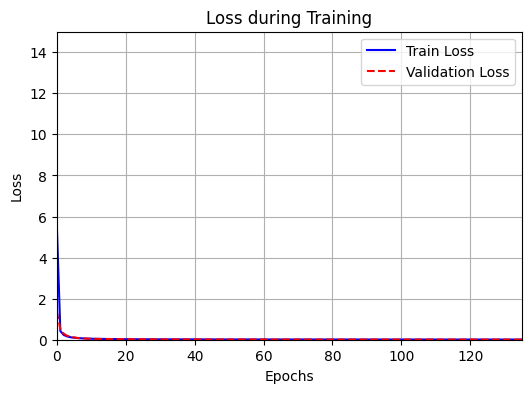

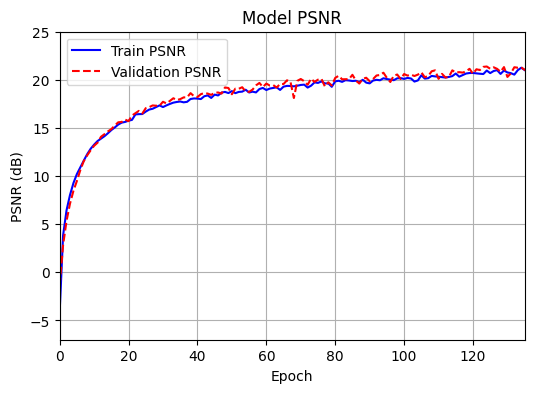

In [ ]:
## loss, PNSR 출력 ##
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
PSNR_values = history.history['PSNR']
val_PSNR_values = history.history['val_PSNR']

# 원하는 epoch 범위 설정
start_epoch = 0
end_epoch = 135 #155

# Loss 그래프 출력
plt.figure(figsize=(6, 4))
plt.plot(loss_values, label='Train Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='red', linestyle='dashed')
plt.xlim(start_epoch, end_epoch)
plt.ylim(0, 15)
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# PSNR 그래프 출력
plt.figure(figsize=(6, 4))
plt.plot(PSNR_values, label='Train PSNR', color='blue')
plt.plot(val_PSNR_values, label='Validation PSNR', color='red', linestyle='dashed')
plt.xlim(start_epoch, end_epoch)
plt.ylim(-7, 25)
plt.title('Model PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 0s 52ms/step
Low Resolution (u) range: -1.39857017993927 to 2.252159595489502
SRCNN Prediction (u) range: -1.3967316150665283 to 1.2373859882354736
High Resolution (Ground Truth) (u) range: -1.551876425743103 to 1.4467999935150146


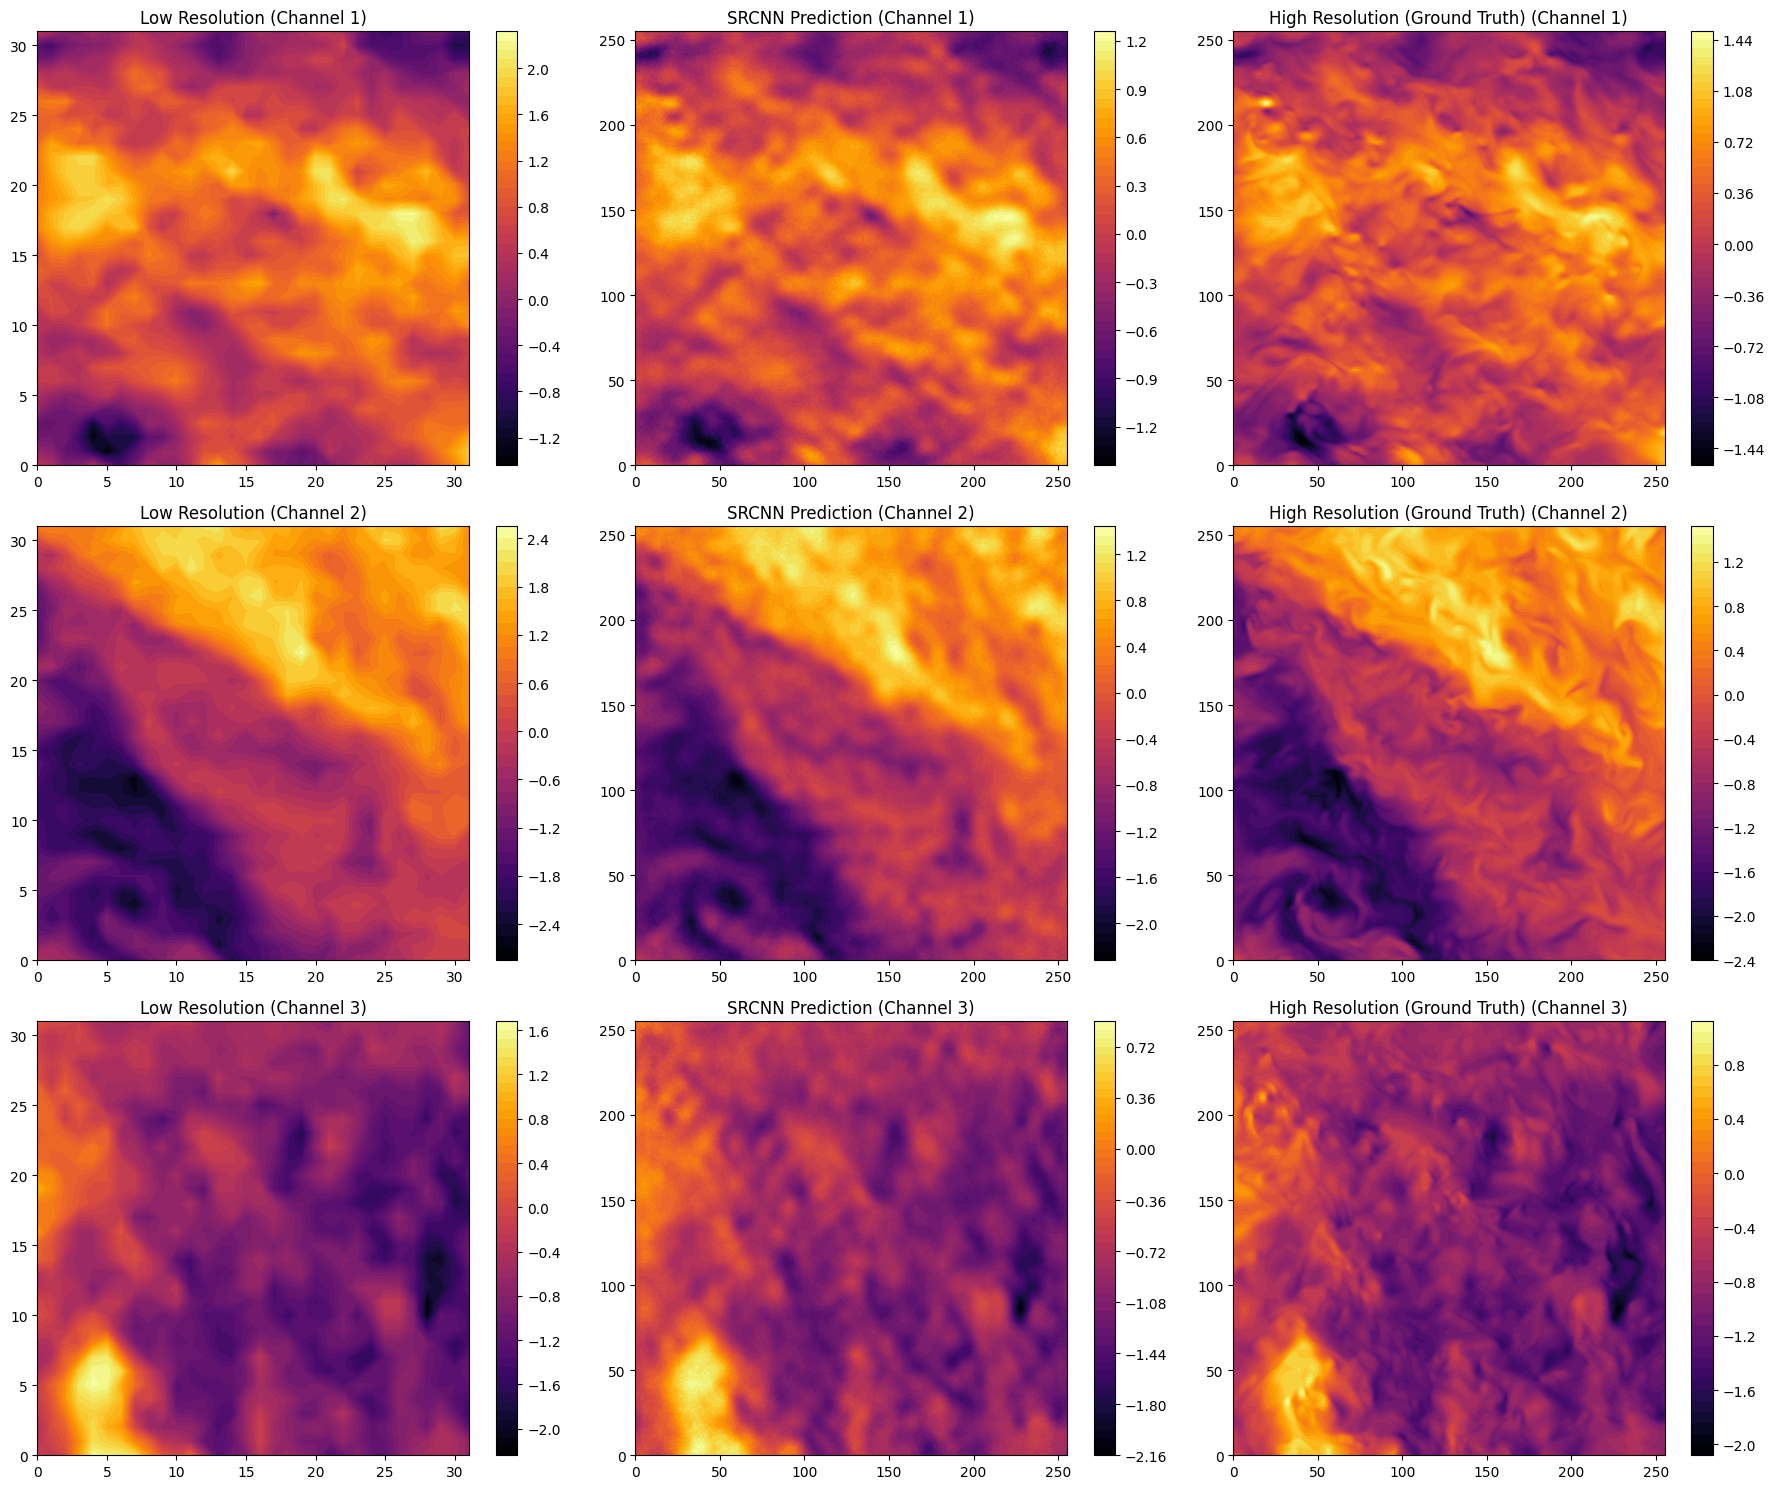

In [ ]:
## 결과 시각화_등고선(contour) ##
## contour보단 colormap이 good ##

import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, 200)
lr_img_in = lr_test[idx]
hr_img_test = test_data[idx]
predicted_img = esrcnn_model.predict(lr_img_in[np.newaxis, :])[0]

print(f"Low Resolution (u) range: {lr_img_in[:, :, 0].min()} to {lr_img_in[:, :, 0].max()}")
print(f"SRCNN Prediction (u) range: {predicted_img[:, :, 0].min()} to {predicted_img[:, :, 0].max()}")
print(f"High Resolution (Ground Truth) (u) range: {hr_img_test[:, :, 0].min()} to {hr_img_test[:, :, 0].max()}")

# 채널별로 3개의 subplot을 생성
fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 각 채널에 대해 Low Resolution, SRCNN Prediction, High Resolution 출력
for i in range(3):
    # Low Resolution
    contour11 = axes[i, 0].contourf(lr_img_in[:, :, i], levels=50, cmap='inferno')
    fig.colorbar(contour11, ax=axes[i, 0])
    axes[i, 0].set_title(f"Low Resolution (Channel {i+1})")

    # SRCNN Prediction
    contour21 = axes[i, 1].contourf(predicted_img[:, :, i], levels=50,cmap='inferno')
    fig.colorbar(contour21, ax=axes[i, 1])
    axes[i, 1].set_title(f"SRCNN Prediction (Channel {i+1})")

    # High Resolution (Ground Truth)
    contour31 = axes[i, 2].contourf(hr_img_test[:, :, i], levels=50,cmap='inferno')
    fig.colorbar(contour31, ax=axes[i, 2])
    axes[i, 2].set_title(f"High Resolution (Ground Truth) (Channel {i+1})")

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 137ms/step
Low Resolution (u) range: -1.124075174331665 to 0.16325432062149048
SRCNN Prediction (u) range: -1.252187967300415 to 1.4788517951965332
High Resolution (Ground Truth) (u) range: -1.514570951461792 to 1.6211901903152466


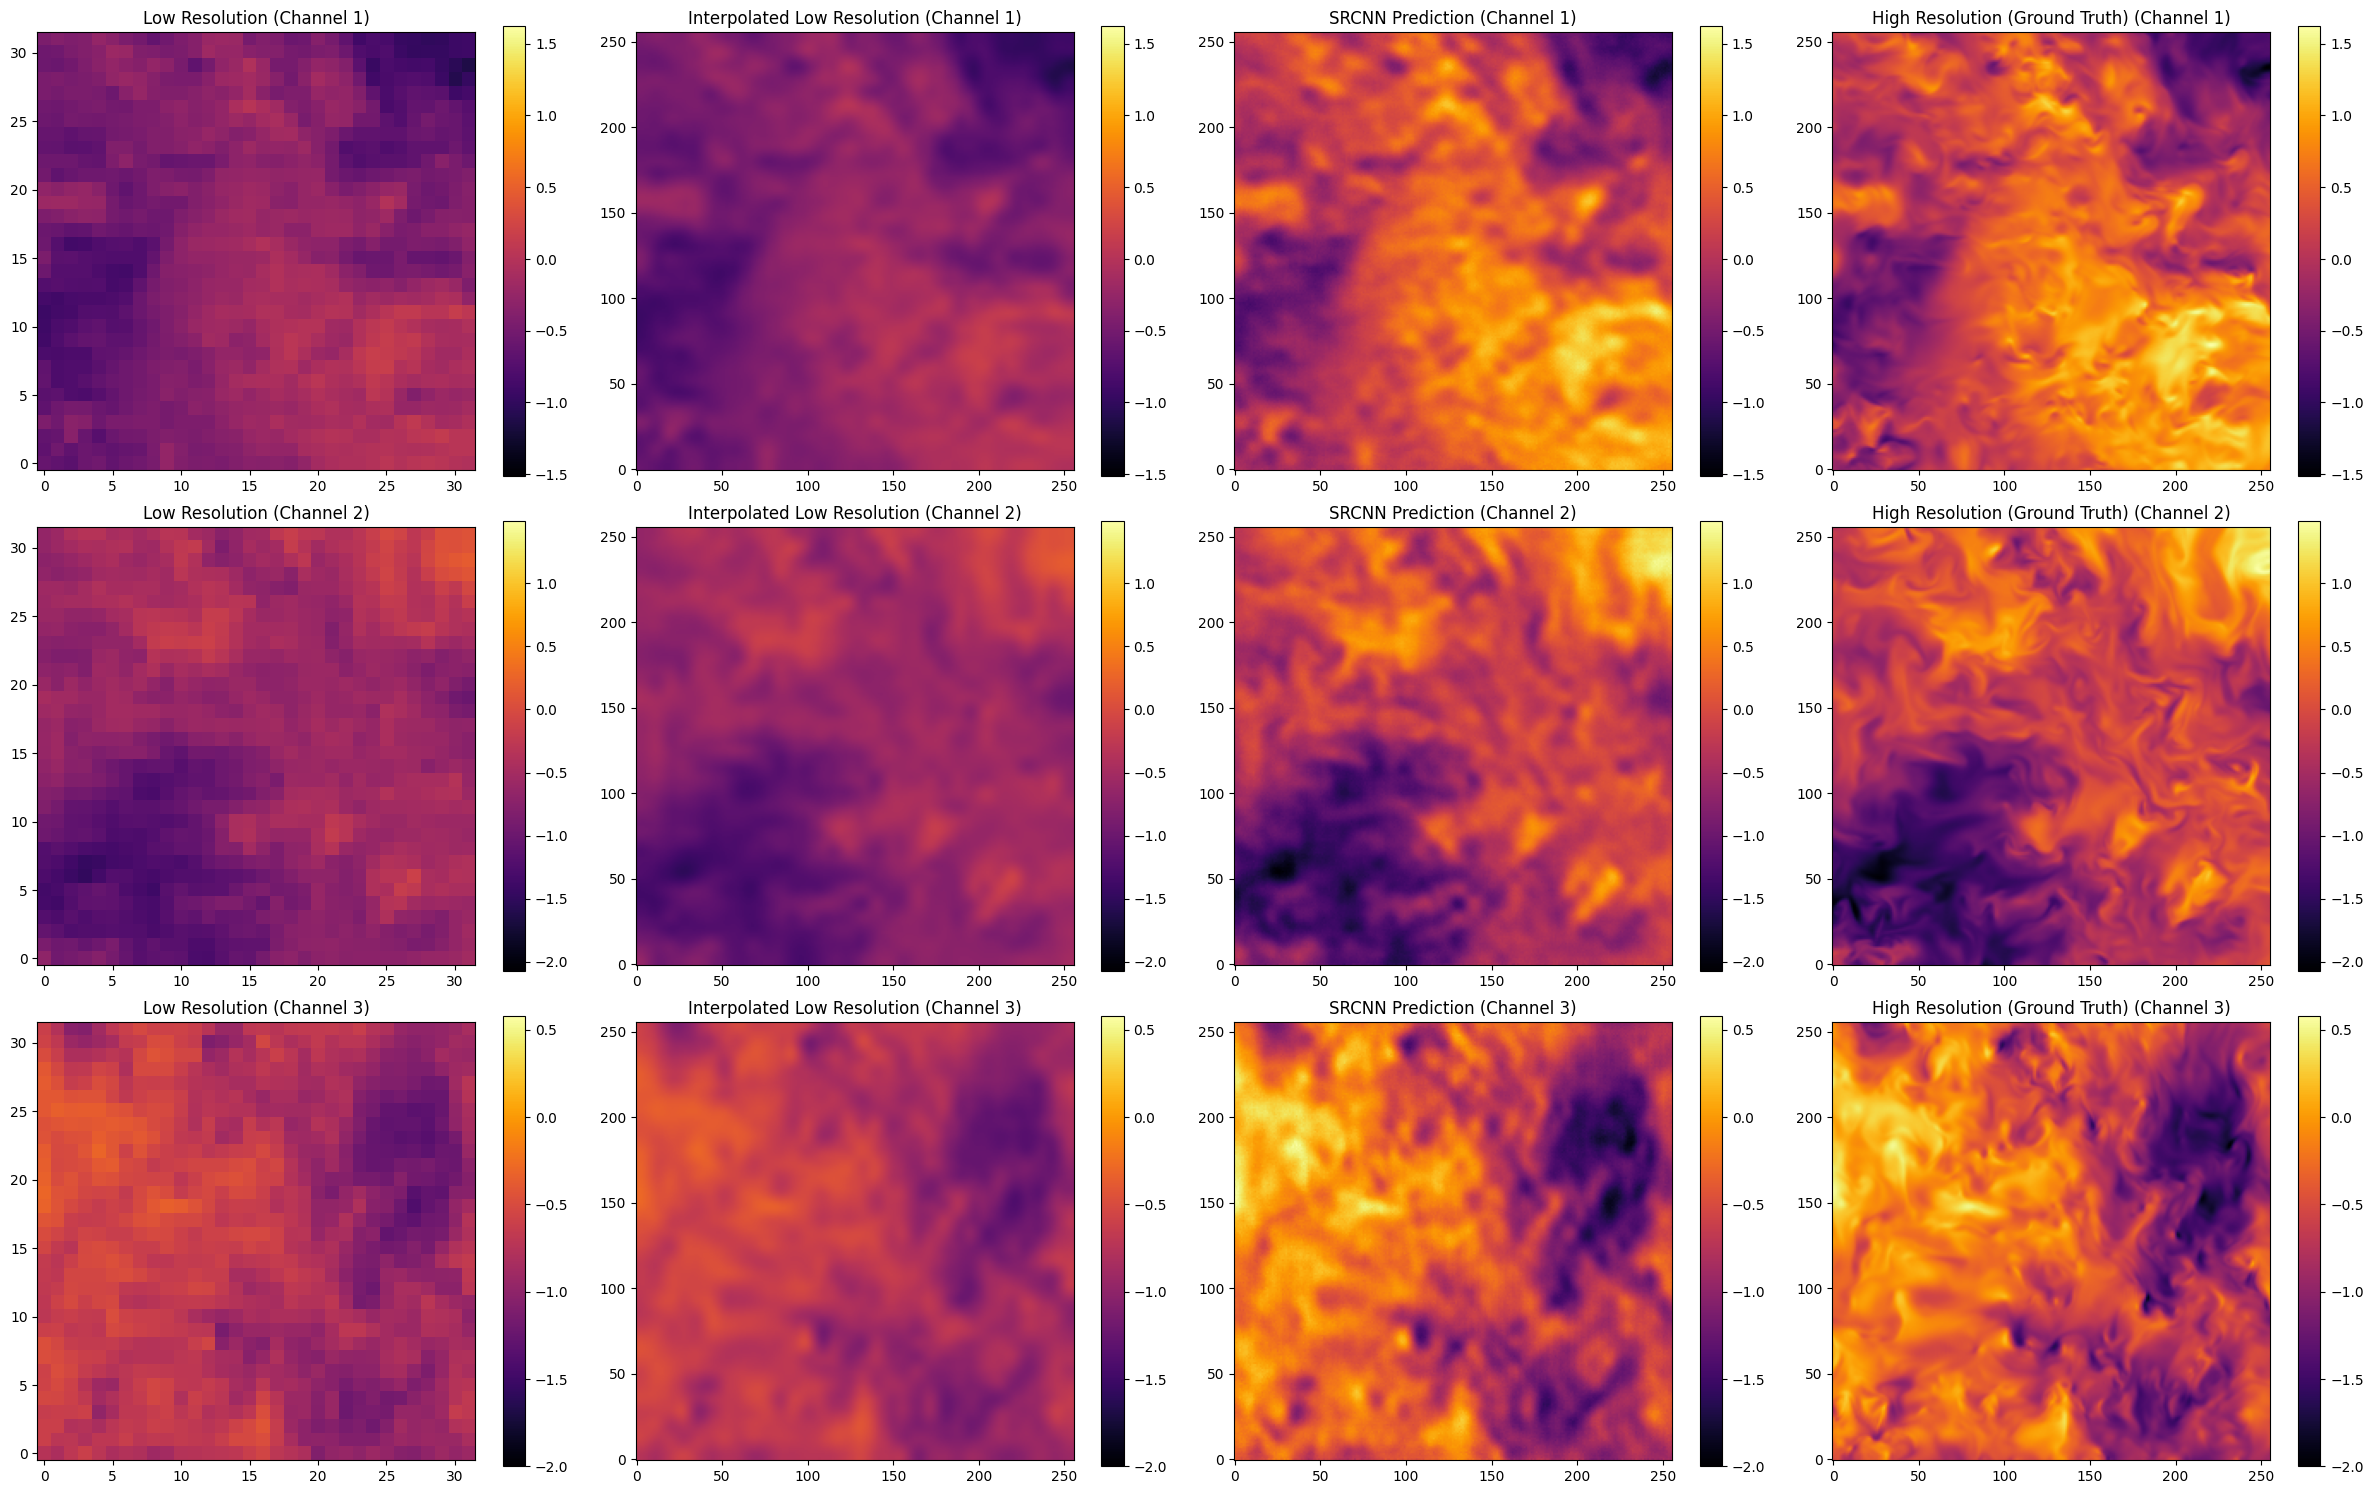

In [ ]:
## 결과 시각화_컬러맵(imshow) ##
size = hr_train.shape[1]
idx = np.random.randint(0, 200)
lr_img_in = lr_test[idx]
lr_img_show = - (lr_img_in * mean_val + std_val)
bicubic_img = cv2.resize(lr_img_show, (size, size), interpolation=cv2.INTER_CUBIC)
hr_img_test = test_data[idx]
predicted_img = esrcnn_model2.predict(lr_img_in[np.newaxis, :])[0]

print(f"Low Resolution (u) range: {lr_img_show[:, :, 0].min()} to {lr_img_show[:, :, 0].max()}")
print(f"SRCNN Prediction (u) range: {predicted_img[:, :, 0].min()} to {predicted_img[:, :, 0].max()}")
print(f"High Resolution (Ground Truth) (u) range: {hr_img_test[:, :, 0].min()} to {hr_img_test[:, :, 0].max()}")

# 채널별로 4개의 subplot을 생성
fig, axes = plt.subplots(3, 4, figsize=(24, 15))

# 각 채널에 대해 Low Resolution, Interpolated Low Resolution, SRCNN Prediction, High Resolution 출력
for i in range(3):
    vmin = min(lr_img_show[:, :, i].min(), predicted_img[:, :, i].min(), hr_img_test[:, :, i].min())
    vmax = max(lr_img_show[:, :, i].max(), predicted_img[:, :, i].max(), hr_img_test[:, :, i].max())

    # Low Resolution
    im1 = axes[i, 0].imshow(lr_img_show[:, :, i], cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    fig.colorbar(im1, ax=axes[i, 0])
    axes[i, 0].set_title(f"Low Resolution (Channel {i+1})")

    # Interpolated Low Resolution(bicubic interpolation) ** 크기 확인 **
    im2 = axes[i, 1].imshow(bicubic_img[:, :, i], cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    fig.colorbar(im2, ax=axes[i, 1])
    axes[i, 1].set_title(f"Interpolated Low Resolution (Channel {i+1})")

    # SRCNN Prediction
    im3 = axes[i, 2].imshow(predicted_img[:, :, i], cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    fig.colorbar(im3, ax=axes[i, 2])
    axes[i, 2].set_title(f"SRCNN Prediction (Channel {i+1})")

    # High Resolution (Ground Truth)
    im4 = axes[i, 3].imshow(hr_img_test[:, :, i], cmap='inferno', vmin=vmin, vmax=vmax, origin='lower')
    fig.colorbar(im4, ax=axes[i, 3])
    axes[i, 3].set_title(f"High Resolution (Ground Truth) (Channel {i+1})")

plt.tight_layout()
plt.show()

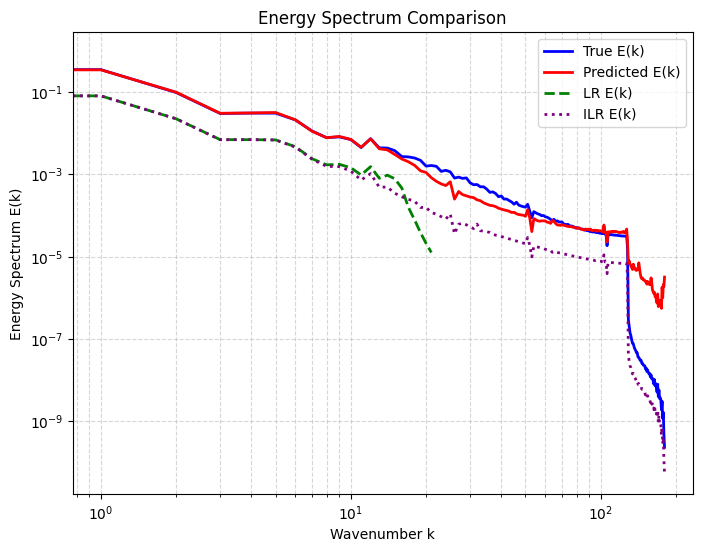

In [ ]:
## 원본과 복원된 에너지 스펙트럼 비교, k_bin을 선형적으로 분할 ##
def compute_energy_spectrum(u, v, w):
    """
    속도장(u, v, w)에 대한 에너지 스펙트럼을 계산하는 함수.

    Parameters:
    u (numpy.ndarray): x 방향 속도 성분
    v (numpy.ndarray): y 방향 속도 성분
    w (numpy.ndarray): z 방향 속도 성분

    Returns:
    k (numpy.ndarray): 파수 값
    E_k (numpy.ndarray): 에너지 스펙트럼
    """
    # 속도장 크기
    nx, nz = u.shape

    # 푸리에 변환 적용 (각 속도 성분에 대해)
    u_hat = np.fft.fft2(u) / (nx * nz)
    v_hat = np.fft.fft2(v) / (nx * nz)
    w_hat = np.fft.fft2(w) / (nx * nz)

    # 푸리에 변환 결과를 이동시켜서 중심으로
    u_hat_shifted = np.fft.fftshift(u_hat)
    v_hat_shifted = np.fft.fftshift(v_hat)
    w_hat_shifted = np.fft.fftshift(w_hat)

    # 주파수 벡터 계산 (파수 k_x, k_z)
    dx = 2 * np.pi / nx  # x 방향 공간 간격
    dz = 2 * np.pi / nz  # z 방향 공간 간격

    k_x = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    k_z = np.fft.fftfreq(nz, d=dz) * 2 * np.pi

    k_x = np.fft.fftshift(k_x)
    k_z = np.fft.fftshift(k_z)

    # k_x, k_z에 대해 그리드 생성
    k_x, k_z = np.meshgrid(k_x, k_z, indexing='ij')
    k = np.sqrt(k_x**2 + k_z**2)  # 전체 파수 k 계산

    # 에너지 스펙트럼 계산 (속도 성분의 제곱합)
    energy_spectrum = 0.5 * (np.abs(u_hat_shifted)**2 + np.abs(v_hat_shifted)**2 + np.abs(w_hat_shifted)**2)

    # k_bins 정의 (파수 범위 설정)
    k_bins = np.arange(0, np.max(k), 1)
    E_k = np.zeros_like(k_bins[:-1])

    # 각 파수 구간에 대해 에너지 집계
    for i in range(len(k_bins) - 1):
        indices = (k >= k_bins[i]) & (k < k_bins[i + 1])
        E_k[i] = np.sum(energy_spectrum[indices])

    # 정규화
    E_k = E_k / np.sum(E_k)

    return k_bins[:-1], E_k

# 예측된 이미지와 실제 고해상도 이미지 데이터
u_lr = lr_img_show[:, :, 0]
v_lr = lr_img_show[:, :, 1]
w_lr = lr_img_show[:, :, 2]

u_ilr = bicubic_img[:, :, 0]
v_ilr = bicubic_img[:, :, 1]
w_ilr = bicubic_img[:, :, 2]

u_pred = predicted_img[:, :, 0]
v_pred = predicted_img[:, :, 1]
w_pred = predicted_img[:, :, 2]

u_true = hr_img_test[:, :, 0]
v_true = hr_img_test[:, :, 1]
w_true = hr_img_test[:, :, 2]

# 함수 호출
k_lr, E_k_lr = compute_energy_spectrum(u_lr, v_lr, w_lr)
k_ilr, E_k_ilr = compute_energy_spectrum(u_ilr, v_ilr, w_ilr)
k_pred, E_k_pred = compute_energy_spectrum(u_pred, v_pred, w_pred)
k_true, E_k_true = compute_energy_spectrum(u_true, v_true, w_true)

# 시각화
plt.figure(figsize=(8, 6))
plt.loglog(k_true, E_k_true, label="True E(k)", linewidth=2, color='b')
plt.loglog(k_pred, E_k_pred, label="Predicted E(k)", linewidth=2, color='r')
plt.loglog(k_lr, E_k_lr, label="LR E(k)", linewidth=2, linestyle='dashed', color='g')
plt.loglog(k_ilr, E_k_ilr, label="ILR E(k)", linewidth=2, linestyle='dotted', color='purple')

plt.xlabel("Wavenumber k")
plt.ylabel("Energy Spectrum E(k)")
plt.title("Energy Spectrum Comparison")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

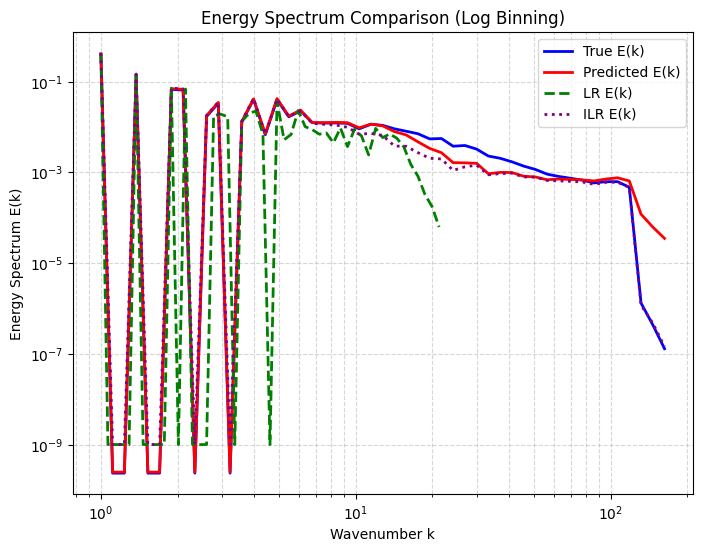

In [ ]:
## k_bin을 log scale로 분할 ##
def compute_energy_spectrum(u, v, w):
    nx, nz = u.shape  # 격자 크기

    # FFT 수행
    u_hat = np.fft.fft2(u) / (nx * nz)
    v_hat = np.fft.fft2(v) / (nx * nz)
    w_hat = np.fft.fft2(w) / (nx * nz)

    # FFT 결과를 중앙 정렬
    u_hat_shifted = np.fft.fftshift(u_hat)
    v_hat_shifted = np.fft.fftshift(v_hat)
    w_hat_shifted = np.fft.fftshift(w_hat)

    # 주파수 축 설정
    dx = 2 * np.pi / nx  # x 방향 공간 간격
    dz = 2 * np.pi / nz  # z 방향 공간 간격

    k_x = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    k_z = np.fft.fftfreq(nz, d=dz) * 2 * np.pi

    k_x = np.fft.fftshift(k_x)
    k_z = np.fft.fftshift(k_z)

    k_x, k_z = np.meshgrid(k_x, k_z, indexing='ij')
    k = np.sqrt(k_x**2 + k_z**2)  # 방사형 파수

    # 에너지 스펙트럼 계산
    energy_spectrum = 0.5 * (np.abs(u_hat_shifted)**2 + np.abs(v_hat_shifted)**2 + np.abs(w_hat_shifted)**2)

    # 로그 스케일 binning 적용
    k_min = np.min(k[k > 0])  # 0을 제외한 최소 k 값
    k_max = np.max(k)
    num_bins = 50  # 원하는 bin 개수

    k_bins = np.logspace(np.log10(k_min), np.log10(k_max), num_bins)
    E_k = np.zeros(len(k_bins) - 1)

    # 각 bin에 대해 에너지 적산
    for i in range(len(k_bins) - 1):
        indices = (k >= k_bins[i]) & (k < k_bins[i + 1])
        E_k[i] = np.sum(energy_spectrum[indices])

    # 정규화
    E_k = np.clip(E_k, 1e-10, None)  # 최소값 설정
    E_k = E_k / (np.sum(E_k) + 1e-10)  # 작은 값 추가

    return k_bins[:-1], E_k

# 예측된 이미지와 실제 고해상도 이미지 데이터
u_lr = lr_img_show[:, :, 0]
v_lr = lr_img_show[:, :, 1]
w_lr = lr_img_show[:, :, 2]

u_ilr = bicubic_img[:, :, 0]
v_ilr = bicubic_img[:, :, 1]
w_ilr = bicubic_img[:, :, 2]

u_pred = predicted_img[:, :, 0]
v_pred = predicted_img[:, :, 1]
w_pred = predicted_img[:, :, 2]

u_true = hr_img_test[:, :, 0]
v_true = hr_img_test[:, :, 1]
w_true = hr_img_test[:, :, 2]

# 함수 호출
k_lr, E_k_lr = compute_energy_spectrum(u_lr, v_lr, w_lr)
k_ilr, E_k_ilr = compute_energy_spectrum(u_ilr, v_ilr, w_ilr)
k_pred, E_k_pred = compute_energy_spectrum(u_pred, v_pred, w_pred)
k_true, E_k_true = compute_energy_spectrum(u_true, v_true, w_true)

# 시각화
plt.figure(figsize=(8, 6))
plt.loglog(k_true, E_k_true, label="True E(k)", linewidth=2, color='b')
plt.loglog(k_pred, E_k_pred, label="Predicted E(k)", linewidth=2, color='r')
plt.loglog(k_lr, E_k_lr, label="LR E(k)", linewidth=2, linestyle='dashed', color='g')
plt.loglog(k_ilr, E_k_ilr, label="ILR E(k)", linewidth=2, linestyle='dotted', color='purple')

plt.xlabel("Wavenumber k")
plt.ylabel("Energy Spectrum E(k)")
plt.title("Energy Spectrum Comparison (Log Binning)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.show()

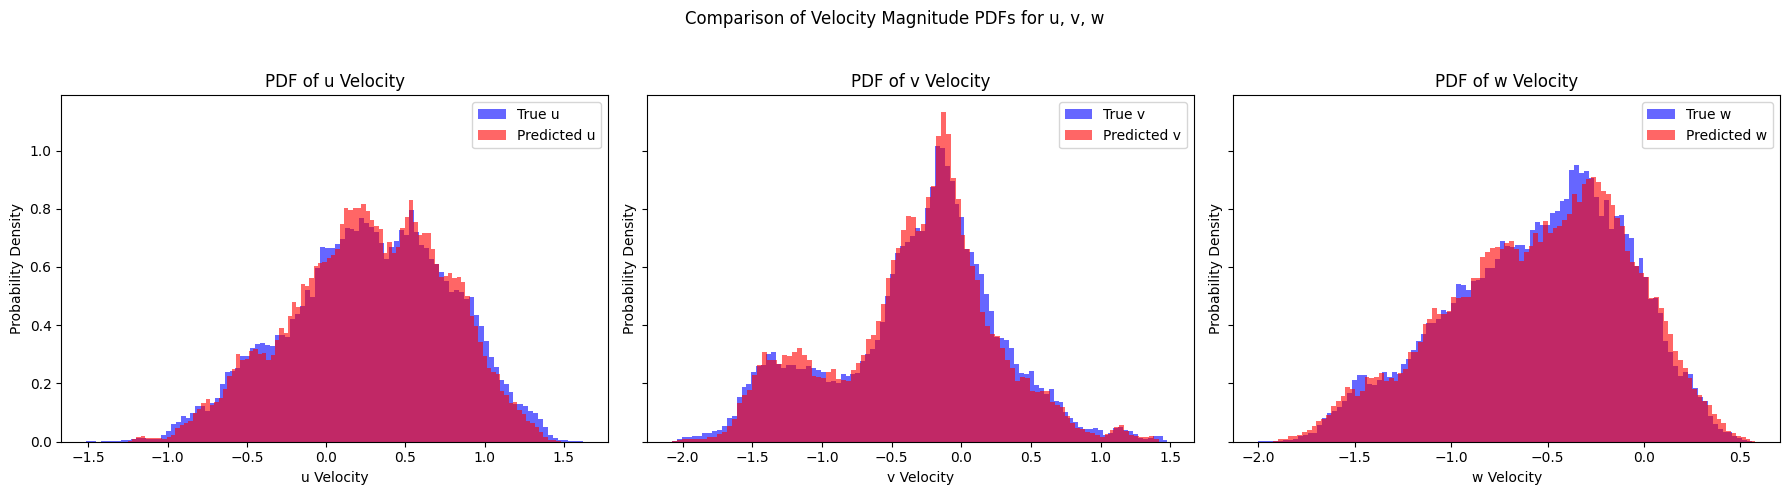

In [ ]:
## 원본과 복원된 속도장 비교 ##
# 각 속도 성분 추출 (u: 0, v: 1, w: 2)
u_true = hr_img_test[:, :, 0].flatten()
v_true = hr_img_test[:, :, 1].flatten()
w_true = hr_img_test[:, :, 2].flatten()

u_pred = predicted_img[:, :, 0].flatten()
v_pred = predicted_img[:, :, 1].flatten()
w_pred = predicted_img[:, :, 2].flatten()

# 속도 성분 이름과 데이터 리스트
components = ["u", "v", "w"]
true_components = [u_true, v_true, w_true]
pred_components = [u_pred, v_pred, w_pred]

# 히스토그램 그리기
bins = 100
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i in range(3):
    axes[i].hist(true_components[i], bins=bins, density=True, alpha=0.6, label="True " + components[i], color='blue')
    axes[i].hist(pred_components[i], bins=bins, density=True, alpha=0.6, label="Predicted " + components[i], color='red')
    axes[i].set_xlabel(f"{components[i]} Velocity")
    axes[i].set_ylabel("Probability Density")
    axes[i].legend()
    axes[i].set_title(f"PDF of {components[i]} Velocity")

plt.suptitle("Comparison of Velocity Magnitude PDFs for u, v, w")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

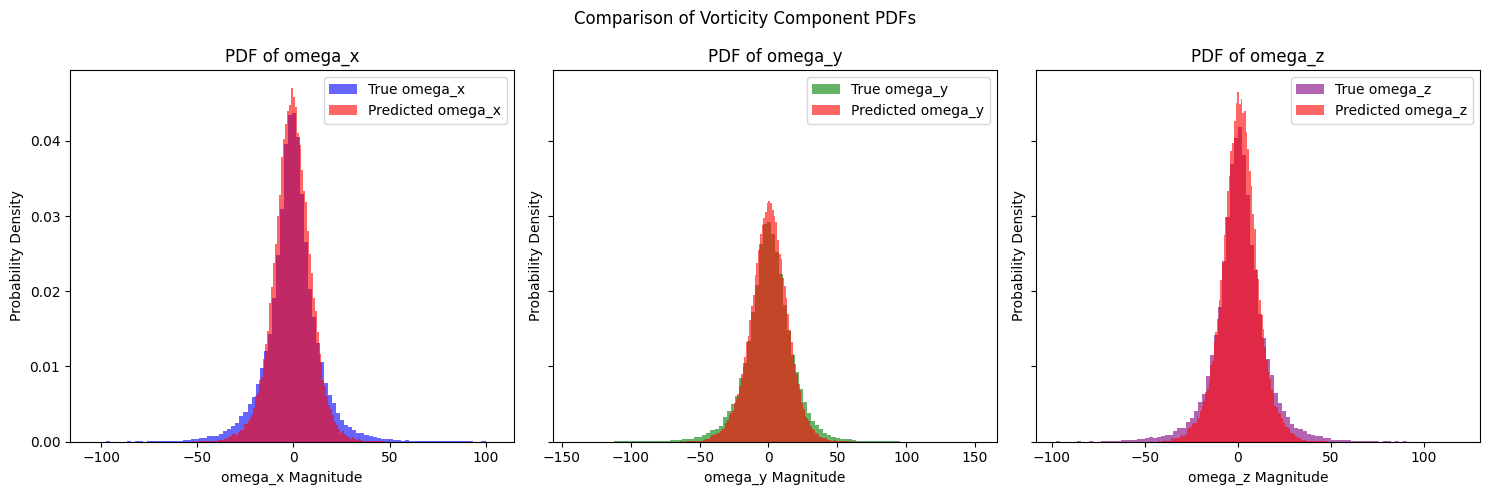

In [ ]:
# 격자 크기 (256, 1, 256)
Nx, Ny, Nz = 256, 1, 256

# 격자 간격 설정
dx = 1.0 / Nx  # dx = 1/128
dy = 1.0 / Ny  # dy = 1/1 (실제 의미 없음)
dz = 1.0 / Nz  # dz = 1/128

# 와도 계산 함수
def compute_vorticity(u, v, w, dx, dy, dz):
    """
    주어진 속도 성분 u, v, w에 대해 와도 벡터를 계산하는 함수
    """
    u = u.reshape(Nx, Ny, Nz)
    v = v.reshape(Nx, Ny, Nz)
    w = w.reshape(Nx, Ny, Nz)

    dvdx = np.gradient(v, dx, axis=0)  # dv/dx
    dudy = 0
    # np.gradient(u, dy, axis=1)  # du/dy
    dwdx = np.gradient(w, dx, axis=0)  # dw/dx
    dvdz = np.gradient(v, dz, axis=2)  # dv/dz
    dwdy = 0
    # np.gradient(w, dy, axis=1)  # dw/dy
    dudz = np.gradient(u, dz, axis=2)  # du/dz

    omega_x = dwdy - dvdz  # ω_x = (∂w/∂y - ∂v/∂z) -> dy 관련 항이 무의미
    omega_y = dudz - dwdx  # ω_y = (∂u/∂z - ∂w/∂x)
    omega_z = dvdx - dudy  # ω_z = (∂v/∂x - ∂u/∂y) -> dy 관련 항이 무의미

    return omega_x, omega_y, omega_z

# 실제 속도장과 예측 속도장의 와도 계산
omega_x_true, omega_y_true, omega_z_true = compute_vorticity(u_true, v_true, w_true, dx, dy, dz)
omega_x_pred, omega_y_pred, omega_z_pred = compute_vorticity(u_pred, v_pred, w_pred, dx, dy, dz)

# 1D 배열로 변환하여 히스토그램 작성
bins = 100
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

omega_components = ["omega_x", "omega_y", "omega_z"]
true_vorticities = [omega_x_true, omega_y_true, omega_z_true]
pred_vorticities = [omega_x_pred, omega_y_pred, omega_z_pred]
colors = ['blue', 'green', 'purple']

for i in range(3):
    true_data = true_vorticities[i].flatten()
    pred_data = pred_vorticities[i].flatten()

    axes[i].hist(true_data, bins=bins, density=True, alpha=0.6, label="True " + omega_components[i], color=colors[i])
    axes[i].hist(pred_data, bins=bins, density=True, alpha=0.6, label="Predicted " + omega_components[i], color='red')

    axes[i].set_xlabel(f"{omega_components[i]} Magnitude")
    axes[i].set_ylabel("Probability Density")
    axes[i].legend()
    axes[i].set_title(f"PDF of {omega_components[i]}")

plt.suptitle("Comparison of Vorticity Component PDFs")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import pearsonr
from skimage.metrics import structural_similarity as ssim

true_velocity = hr_img_test[:, :, :].flatten()
pred_velocity = predicted_img[:, :, :].flatten()

# 두 속도장 간의 피어슨 상관계수 계산
corr, _ = pearsonr(true_velocity, pred_velocity)
print(f"Pearson Correlation Coefficient: {corr}")

# SSIM 계산 (채널별 비교)
win_size = 3
ssim_value = ssim(hr_img_test, predicted_img, multichannel=True, win_size=win_size, data_range=predicted_img.max() - predicted_img.min())
print(f"SSIM: {ssim_value:.4f}")

Pearson Correlation Coefficient: 0.9902971240340582
SSIM: 0.8957


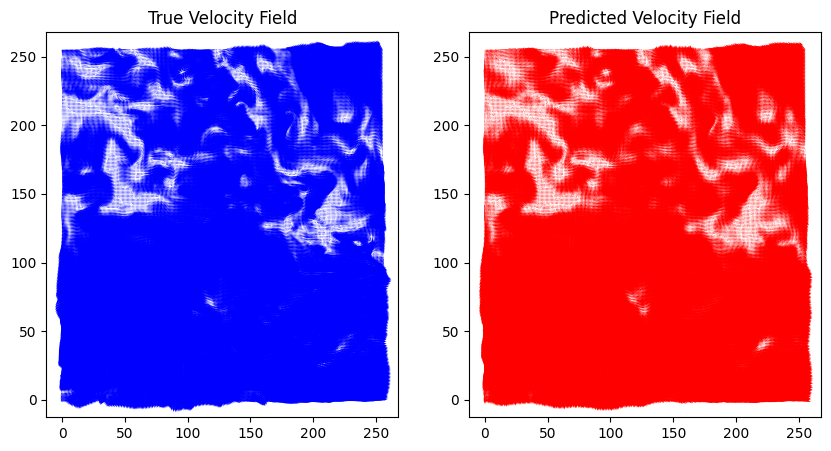

In [ ]:
# 속도장 데이터 (u, v) 구성
u_true, v_true = hr_img_test[:, :, 0], hr_img_test[:, :, 1]
u_pred, v_pred = predicted_img[:, :, 0], predicted_img[:, :, 1]

# 격자 생성
x, y = np.meshgrid(np.arange(u_true.shape[1]), np.arange(u_true.shape[0]))

plt.figure(figsize=(10, 5))

# 원본 속도장
plt.subplot(1, 2, 1)
plt.quiver(x, y, u_true, v_true, scale=50, color='b')
plt.title("True Velocity Field")

# 복원된 속도장
plt.subplot(1, 2, 2)
plt.quiver(x, y, u_pred, v_pred, scale=50, color='r')
plt.title("Predicted Velocity Field")

plt.show()